In [240]:
%matplotlib widget
from mmdet3d.datasets import build_dataset
from tools.misc.browse_dataset import build_data_cfg
from mmdet3d.models import apply_3d_transformation
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import copy
import torch
import numpy as np
from mmdet3d.ops.voxel.voxelize import voxelization
from mmdet3d.ops import DynamicScatter
from mmdet3d.ops import (
    flat2window_v2,
    window2flat_v2,
    get_inner_win_inds,
    make_continuous_inds,
    get_flat2win_inds_v2,
    get_window_coors,
)
import time
import pickle
import random

In [241]:
def proj_points_to_2d(points, proj_mat):
    points = torch.cat(
        [
            points[:, :3].reshape(-1, 3),
            torch.ones((points.shape[0], 1), device=points.device),
        ],
        axis=-1,
    )
    points_2d = torch.mm(points, proj_mat.T)
    points_2d[:, 2] = points_2d[:, 2].clip(min=1e-4, max=1e4)
    points_2d[:, 0] /= points_2d[:, 2]
    points_2d[:, 1] /= points_2d[:, 2]
    return points_2d

def points_in_image(points, image_size=(1600, 900)):
    return (
        (0 <= points[:, 0])
        & (points[:, 0] <= image_size[0])
        & (0 <= points[:, 1])
        & (points[:, 1] <= image_size[1])
    )

def window_partition(sparse_shape, window_shape, coors):
    voxel_info = {}
    for i in range(2):
        # Adds indexation which window (counted across all batches) and which spot in the window
        batch_win_inds, coors_in_win = get_window_coors(
            coors, sparse_shape, window_shape, i == 1
        )
        voxel_info[f"batch_win_inds_shift{i}"] = batch_win_inds
        voxel_info[f"coors_in_win_shift{i}"] = coors_in_win

    return voxel_info

def recover_bev(output_shape, voxel_feat, coors, batch_size):
    '''
    Args:
        voxel_feat: shape=[N, C]
        coors: [N, 4]
    Return:
        batch_canvas:, shape=[B, C, ny, nx]
    '''
    ny, nx = output_shape
    feat_dim = voxel_feat.shape[-1]

    batch_canvas = []
    for batch_itt in range(batch_size):
        # Create the canvas for this sample
        canvas = torch.zeros(
            feat_dim,
            nx * ny,
            dtype=voxel_feat.dtype,
            device=voxel_feat.device)

        # Only include non-empty pillars
        batch_mask = coors[:, 0] == batch_itt
        this_coors = coors[batch_mask, :]
        indices = this_coors[:, 2] * nx + this_coors[:, 3]
        indices = indices.type(torch.long)
        voxels = voxel_feat[batch_mask, :] #[n, c]
        voxels = voxels.t() #[c, n]

        canvas[:, indices] = voxels

        batch_canvas.append(canvas)

    batch_canvas = torch.stack(batch_canvas, 0)

    batch_canvas = batch_canvas.view(batch_size, feat_dim, ny, nx)

    return batch_canvas

In [242]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Load input to middle encoder (sst_input_layer_v2)

In [243]:
with open("sst_input_layer.pkl", "rb") as f:
    sst_input_layer = pickle.load(f)

voxel_feats, voxel_coors, voxel_mean, img_metas, batch_size = sst_input_layer

### SST input layer

In [244]:
use_image_partition = False

if use_image_partition:
    # Get projection matrix
    proj_mats = [
        torch.Tensor(img_meta["lidar2img"][0].reshape(4, 4)).to(voxel_mean.device)
        for img_meta in img_metas
    ]

    # Find batch ranges
    batch_start_inds = [
        torch.where(voxel_coors[:, 0] == b)[0][0] for b in range(batch_size)
    ]
    batch_ranges = [
        (batch_start_inds[b], batch_start_inds[b + 1])
        for b in range(batch_size - 1)
    ]
    batch_ranges.append((batch_start_inds[-1], voxel_coors.shape[0]))


    # Project voxel mean to 2d
    voxel_mean_2d = torch.zeros_like(voxel_mean)
    for batch_range, proj_mat in zip(batch_ranges, proj_mats):
        voxel_mean_2d[batch_range[0] : batch_range[1], :] = proj_points_to_2d(
            voxel_mean[batch_range[0] : batch_range[1], :], proj_mat
        )


    # Filter out points outside image
    is_voxel_mean_in_image = points_in_image(voxel_mean_2d)
    voxel_mean_2d_in_image = voxel_mean_2d[is_voxel_mean_in_image, :]
    voxel_coors = voxel_coors[is_voxel_mean_in_image, :]
    voxel_feats = voxel_feats[is_voxel_mean_in_image, :]


    # Create coordinates in image plane based on projected voxel mean
    voxel_mean_2d_coords = voxel_mean_2d_in_image.flip(1).int()
    voxel_mean_2d_coords[:, 0] = voxel_coors[:, 0]
    voxel_mean_2d_coords[:, 1] = 0
    #voxel_mean_2d_coords = voxel_mean_2d_coords.long()
    voxel_mean_2d_coords = voxel_mean_2d_coords.float()

    # Window partition
    sparse_shape = (1600, 900, 1)
    window_shape = (300, 300, 1)
    voxel_info = window_partition(sparse_shape, window_shape, voxel_mean_2d_coords)
    voxel_info["voxel_feats"] = voxel_feats
    voxel_info["voxel_coors"] = voxel_coors

else:
    sparse_shape = (200, 200, 1)
    window_shape = (16, 16, 1)
    voxel_info = window_partition(sparse_shape, window_shape, voxel_coors)
    voxel_info["voxel_feats"] = voxel_feats
    voxel_info["voxel_coors"] = voxel_coors


### Plot coors painted by window indices

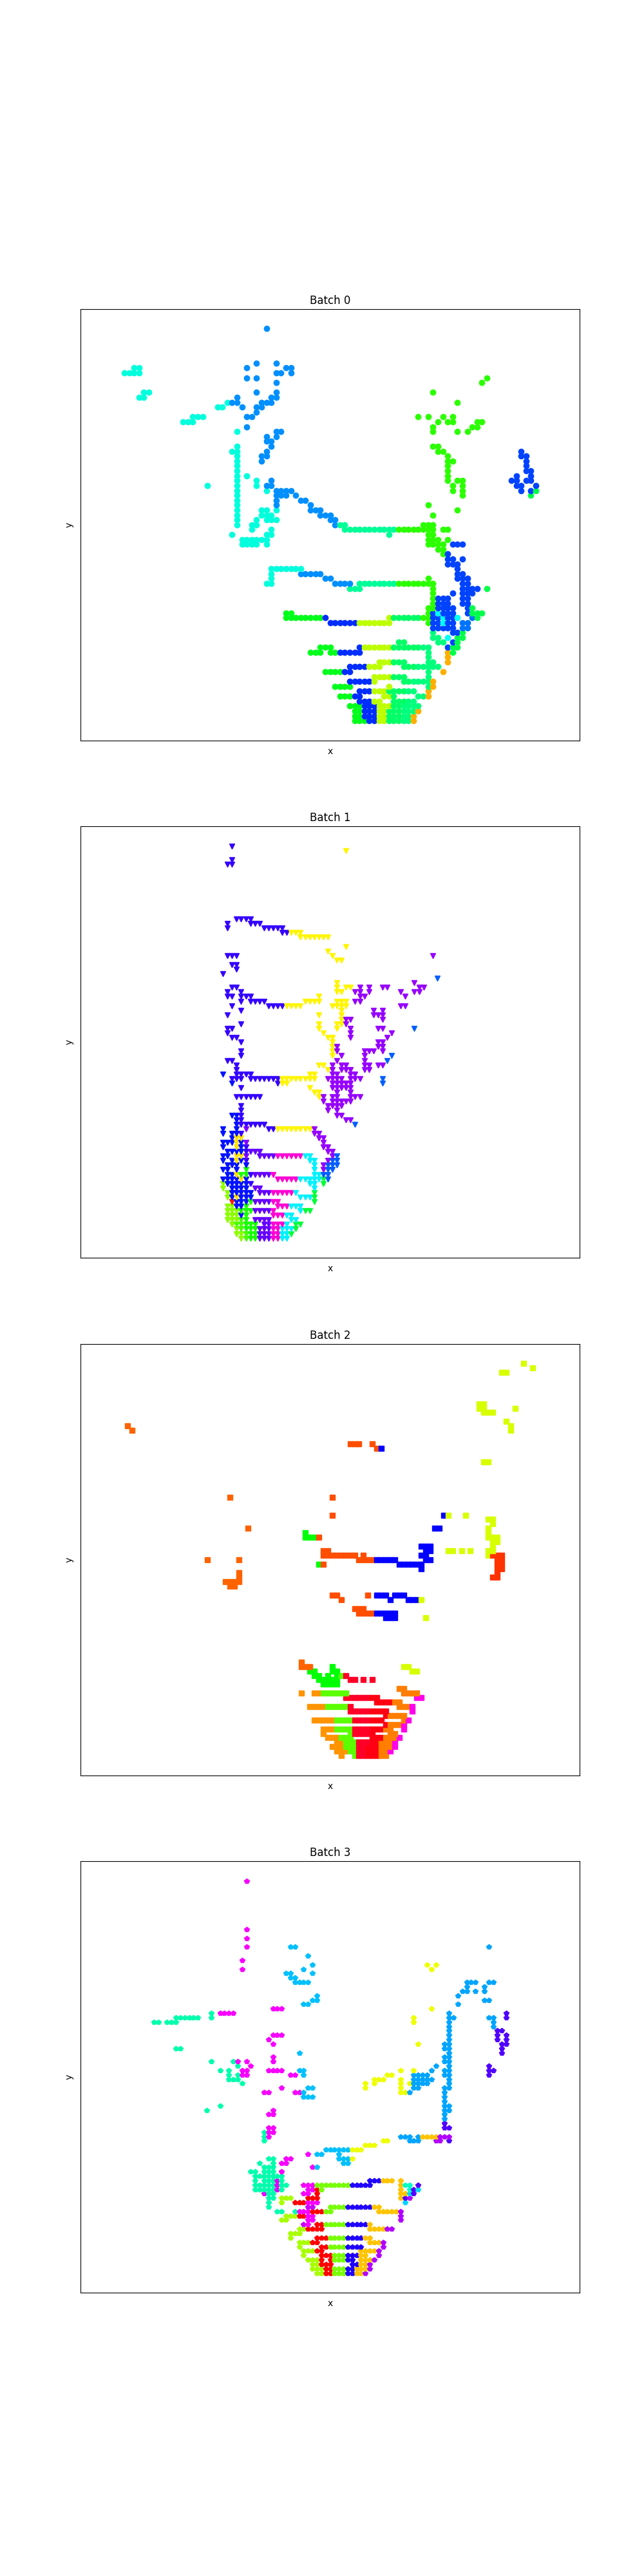

In [245]:
# Create list of colors for each unique value in batch_win_inds_shift0
unique_batch_win_inds = torch.unique(voxel_info["batch_win_inds_shift0"])
color_map = plt.get_cmap("gist_rainbow")
plot_colors = [
    color_map(i / len(unique_batch_win_inds))
    for i in range(len(unique_batch_win_inds))
]
random.shuffle(plot_colors)

# List of plot markers
markers = ["o", "v", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"]

# Plot voxel coors painted by batch win ind
fig, axs = plt.subplots(batch_size, figsize=(10, batch_size * 10))
voxel_coors = voxel_coors.cpu().int()

for i in range(voxel_coors.shape[0]):
    batch_index = voxel_coors[i, 0]
    batch_win_ind = voxel_info["batch_win_inds_shift0"][i]
    color_index = torch.where(unique_batch_win_inds == batch_win_ind)[0]
    axs[batch_index].plot(
        voxel_coors[i, 3],
        voxel_coors[i, 2],
        marker=markers[batch_index],
        color=plot_colors[color_index],
    )

for i in range(batch_size):
    axs[i].set_title(f"Batch {i}")
    axs[i].set_xlabel("x")
    axs[i].set_ylabel("y")
    axs[i].xaxis.set_major_locator(MultipleLocator(window_shape[0]))
    axs[i].xaxis.set_major_formatter(FormatStrFormatter("%d"))
    axs[i].yaxis.set_major_locator(MultipleLocator(window_shape[1]))
    axs[i].xaxis.grid(True, "major", linewidth=2)
    axs[i].yaxis.grid(True, "major", linewidth=2)
    axs[i].axis("equal")

tensor(2072., device='cuda:0')
2072


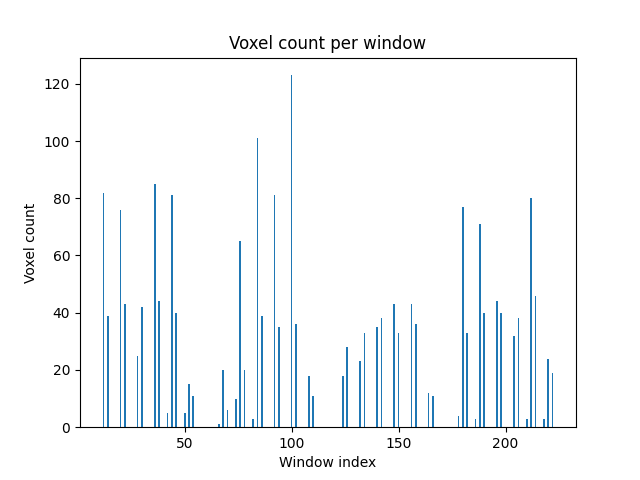

In [246]:
unique_win_ind = voxel_info["batch_win_inds_shift0"].unique()
voxel_count = torch.zeros_like(unique_win_ind)

for i, win_idx in enumerate(unique_win_ind):
    voxel_count[i] = torch.where(voxel_info["batch_win_inds_shift0"] == win_idx)[0].shape[0]

print(voxel_count.sum())
print(voxel_coors.shape[0])
plt.figure()
plt.bar(unique_win_ind.cpu(), voxel_count.cpu())
plt.title("Voxel count per window")
plt.xlabel("Window index")
plt.ylabel("Voxel count")
plt.show()
#print(voxel_count)

In [247]:
print("Voxel count mean: ", voxel_count.mean().item())
print("Voxel count median: ", voxel_count.median().item())
print("Voxel count std: ", voxel_count.std().item())
print("Voxel count min: ", voxel_count.min().item())
print("Voxel count max: ", voxel_count.max().item())

Voxel count mean:  36.35087585449219
Voxel count median:  35.0
Voxel count std:  27.74532699584961
Voxel count min:  1.0
Voxel count max:  123.0


In [248]:
win_ind_in_batch = []
for i in range(batch_size):
    voxel_coors_in_batch = torch.where(voxel_coors[:, 0] == i)[0]
    print(f"Voxel coors in batch {i}: ", voxel_coors_in_batch.shape)
    win_ind_in_batch.append(set(voxel_info["batch_win_inds_shift0"][voxel_coors_in_batch].cpu().numpy()))
    #print(voxel_info["batch_win_inds_shift0"][voxel_coors_in_batch].unique())
    print(f"Win ind in batch {i}: ", len(win_ind_in_batch[i]))
    
# Check if windows intersect between batches
for i in range(batch_size):
    for j in range(batch_size):
        if i != j:
            print(f"Win ind in batch {i} intersect with batch {j}: ", len(win_ind_in_batch[i].intersection(win_ind_in_batch[j])))



#print("Win ind in batch 0", sorted(win_ind_in_batch[0]))
#print("Win ind in batch 1", sorted(win_ind_in_batch[1]))

Voxel coors in batch 0:  torch.Size([593])
Win ind in batch 0:  14
Voxel coors in batch 1:  torch.Size([569])
Win ind in batch 1:  15
Voxel coors in batch 2:  torch.Size([353])
Win ind in batch 2:  12
Voxel coors in batch 3:  torch.Size([557])
Win ind in batch 3:  16
Win ind in batch 0 intersect with batch 1:  0
Win ind in batch 0 intersect with batch 2:  0
Win ind in batch 0 intersect with batch 3:  0
Win ind in batch 1 intersect with batch 0:  0
Win ind in batch 1 intersect with batch 2:  0
Win ind in batch 1 intersect with batch 3:  0
Win ind in batch 2 intersect with batch 0:  0
Win ind in batch 2 intersect with batch 1:  0
Win ind in batch 2 intersect with batch 3:  0
Win ind in batch 3 intersect with batch 0:  0
Win ind in batch 3 intersect with batch 1:  0
Win ind in batch 3 intersect with batch 2:  0


### Plot projected voxel coors

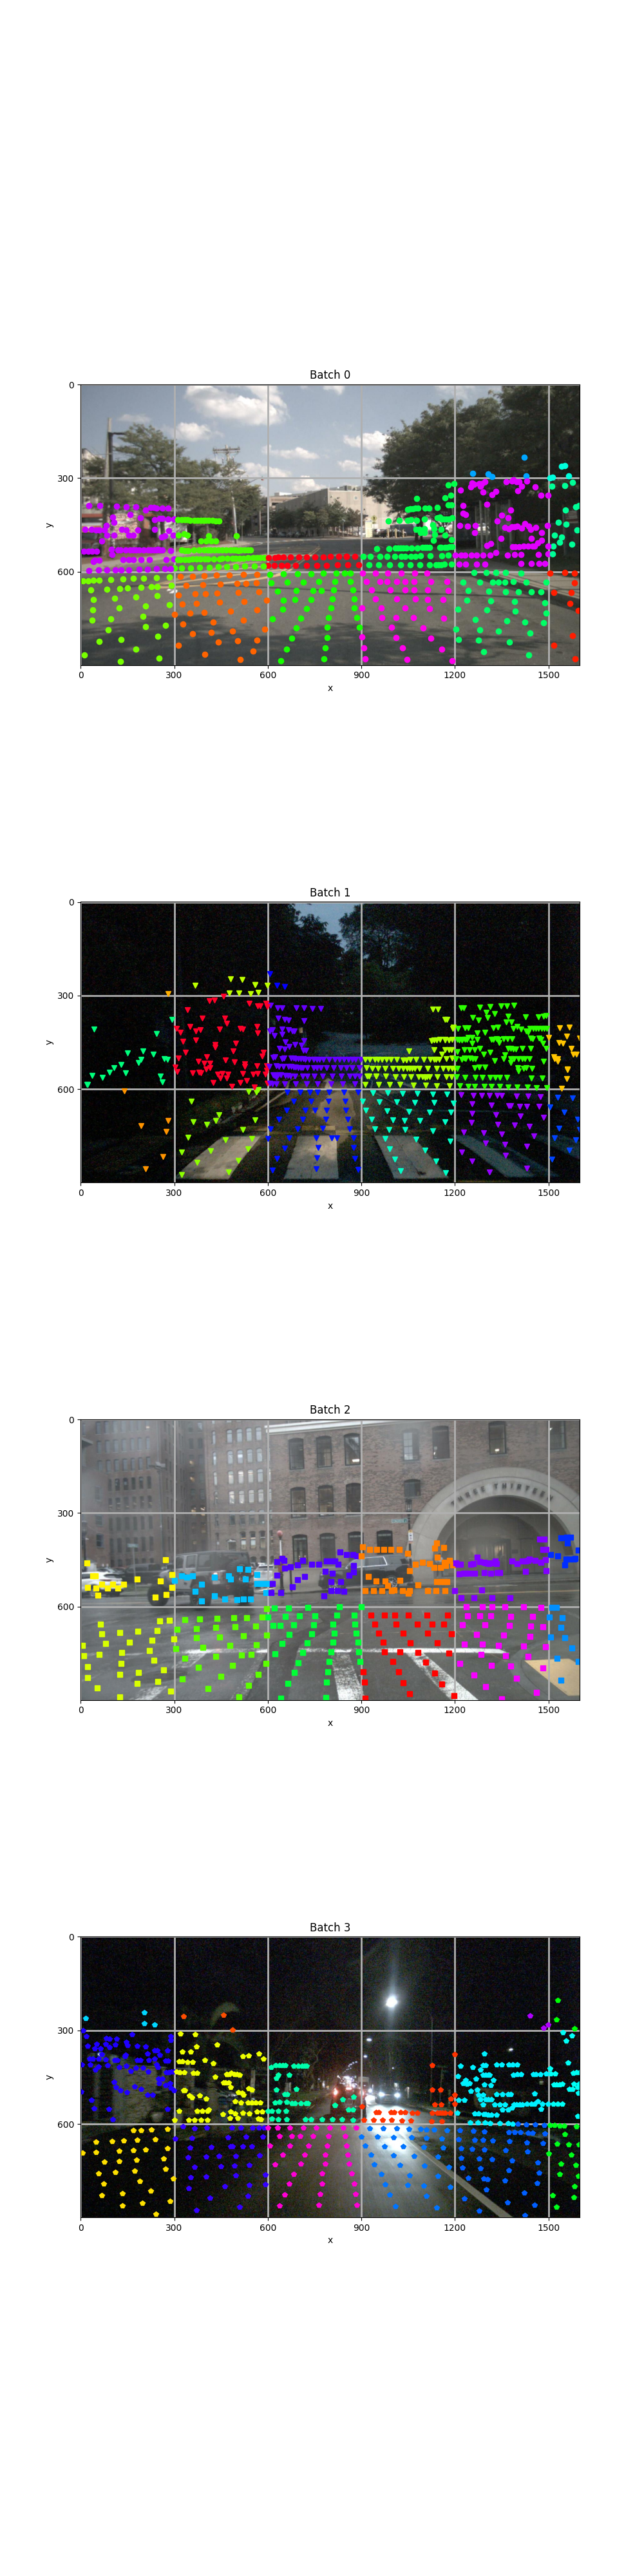

In [249]:
if use_image_partition:
    # Create list of colors for each unique value in batch_win_inds_shift0
    unique_batch_win_inds = torch.unique(voxel_info["batch_win_inds_shift0"])
    color_map = plt.get_cmap("gist_rainbow")
    plot_colors = [
        color_map(i / len(unique_batch_win_inds))
        for i in range(len(unique_batch_win_inds))
    ]
    random.shuffle(plot_colors)

    # List of plot markers
    markers = ["o", "v", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"]


    # Plot voxel coors painted by batch win ind
    fig, axs = plt.subplots(batch_size, 1, figsize=(10, batch_size * 10))
    voxel_mean_2d_coords = voxel_mean_2d_coords.cpu().int()

    for i in range(batch_size):
        front_img = plt.imread(img_metas[i]["filename"][0])
        axs[i].imshow(front_img)


    for i in range(voxel_mean_2d_coords.shape[0]):
        batch_index = voxel_mean_2d_coords[i, 0]
        batch_win_ind = voxel_info["batch_win_inds_shift0"][i]
        color_index = torch.where(unique_batch_win_inds == batch_win_ind)[0]
        axs[batch_index].plot(
            voxel_mean_2d_coords[i, 3],
            voxel_mean_2d_coords[i, 2],
            marker=markers[batch_index],
            color=plot_colors[color_index],
        )

    for i in range(batch_size):
        axs[i].set_title(f"Batch {i}")
        axs[i].set_xlabel("x")
        axs[i].set_ylabel("y")
        axs[i].xaxis.set_major_locator(MultipleLocator(window_shape[0]))
        axs[i].xaxis.set_major_formatter(FormatStrFormatter("%d"))
        axs[i].yaxis.set_major_locator(MultipleLocator(window_shape[1]))
        axs[i].xaxis.grid(True, "major", linewidth=2)
        axs[i].yaxis.grid(True, "major", linewidth=2)
        
else:
    print("Image partition not used.")

### Test BEV recovery

In [250]:
output = recover_bev([200, 200], voxel_info["voxel_feats"], voxel_info["voxel_coors"], batch_size)

In [252]:
output.shape

torch.Size([4, 128, 200, 200])

In [282]:
torch.where(output[0, :, :, :] > 0)[0]

tensor([  0,   0,   0,  ..., 127, 127, 127], device='cuda:0')

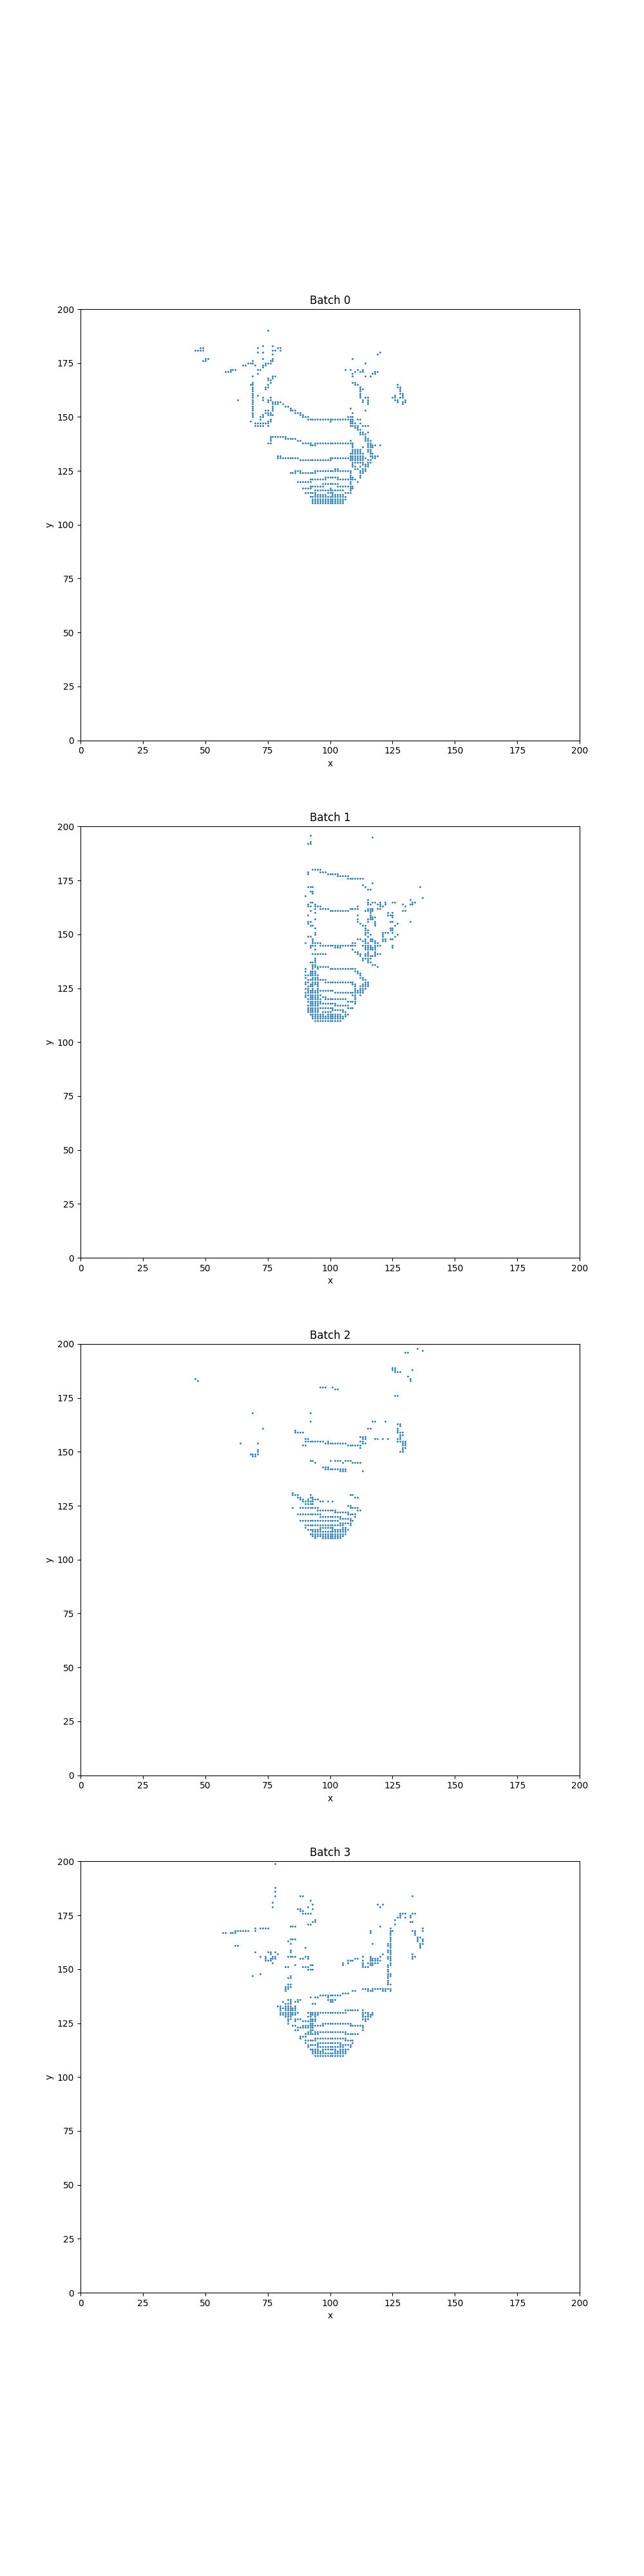

In [310]:
# Plot output
fig, axs = plt.subplots(batch_size, 1, figsize=(10, batch_size * 10))
for i in range(batch_size):
    non_zero_voxels = output[i, :, :, :].sum(dim=0).nonzero().cpu()
    axs[i].scatter(non_zero_voxels[:, 1], non_zero_voxels[:, 0], s=1)
    axs[i].set_title(f"Batch {i}")
    axs[i].set_xlabel("x")
    axs[i].set_ylabel("y")
    #axs[i].xaxis.set_major_locator(MultipleLocator(window_shape[0]))
    #axs[i].xaxis.set_major_formatter(FormatStrFormatter("%d"))
    #axs[i].yaxis.set_major_locator(MultipleLocator(window_shape[1]))
    #axs[i].xaxis.grid(True, "major", linewidth=2)
    #axs[i].yaxis.grid(True, "major", linewidth=2)
    axs[i].set_xlim(0, 200)
    axs[i].set_ylim(0, 200)

In [301]:
output[0, :, :, :].sum(dim=0).nonzero()

tensor([[110,  93],
        [110,  94],
        [110,  95],
        ...,
        [183,  73],
        [183,  77],
        [190,  75]], device='cuda:0')

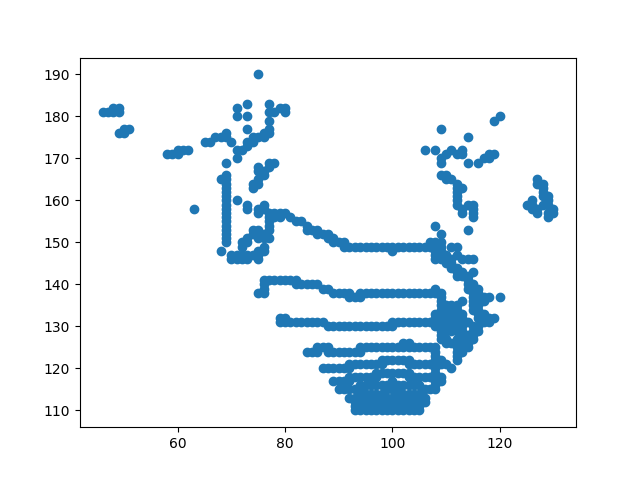

In [304]:
plt.figure()
tmp = output[0, :, :, :].sum(dim=0).nonzero()
plt.scatter(tmp[:, 1].cpu(), tmp[:, 0].cpu())
plt.show()